# PBA Data

Overview & exploration of the PBA dataset.

In [1]:
%matplotlib inline

import os
import warnings
from pathlib import Path
from collections import Counter

import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import pearsonr

import mne

from fooof import FOOOF, FOOOFGroup
from fooof.analysis.periodic import get_band_peak

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_55963/1455357568.py:16: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, FOOOFGroup


## Settings

In [2]:
# Set data path
base_path = Path('/Volumes/Data/01-Internal/PBA/PBA-3/processed/EEG/')

In [3]:
# Set subject file name
subj_fname = '3001_resampled.set'

In [4]:
# Define full path
full_path = base_path / subj_fname

In [5]:
# Check file path exists
assert os.path.exists(full_path)

### Load Data

In [6]:
# Read in subject listed above
full_path = os.path.join(base_path, subj_fname)
eeg = mne.io.read_raw_eeglab(full_path, preload=True) #event_id_func=None, )

Reading /Volumes/Data/01-Internal/PBA/PBA-3/processed/EEG/3001_resampled.fdt
Reading 0 ... 1872017  =      0.000 ...  3744.034 secs...


### Reference

In [7]:
# Set EEG average reference
eeg = eeg.set_eeg_reference()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


### Montage Information

In [8]:
# Create 1020 montage
montage = mne.channels.make_standard_montage('standard_1020')

In [9]:
# Add montage to EEG 
eeg = eeg.set_montage(montage)

### Marking bad channels

Based on visualization.

In [10]:
#eeg.info['bads'] = ['TP9']

In [11]:
#print('Bad channels: ', eeg.info['bads'])

## Events Management

In [12]:
# Get events from annotations
events, event_id = mne.events_from_annotations(eeg, verbose=False)

In [13]:
# Check event IDs
event_id

{'Catch_exp': 1,
 'Catch_instr': 2,
 'Catch_thresh': 3,
 'Con_1_Loc_1': 4,
 'Con_1_Loc_2': 5,
 'Con_1_Loc_3': 6,
 'Con_1_Loc_4': 7,
 'Con_2_Loc_1': 8,
 'Con_2_Loc_2': 9,
 'Con_2_Loc_3': 10,
 'Con_2_Loc_4': 11,
 'Con_3_Loc_1': 12,
 'Con_3_Loc_2': 13,
 'Con_3_Loc_3': 14,
 'Con_3_Loc_4': 15,
 'Exp_Block_End': 16,
 'Exp_Block_Start': 17,
 'Fix_On': 18,
 'Flash_exp': 19,
 'Flash_instr': 20,
 'Flash_thresh': 21,
 'Instructions_End': 22,
 'Instructions_Start': 23,
 'Lines_On': 24,
 'Missed': 25,
 'NUMPAD1 pressed': 26,
 'NUMPAD1 released': 27,
 'RETURN pressed': 28,
 'RETURN released': 29,
 'Recording_End': 30,
 'Recording_Start': 31,
 'Rest_End': 32,
 'Rest_Start': 33,
 'SPACE pressed': 34,
 'SPACE released': 35,
 'Saw': 36,
 'Thresh_Block_End': 37,
 'Thresh_Block_Start': 38}

### Check Events Structure

In [14]:
# Define events to plot
events_plot = {
    'Rest_Start' : event_id['Rest_Start'],
    'Exp_Block_Start' : event_id['Exp_Block_Start'],
}
color = {
    event_id['Rest_Start'] : 'red',
    event_id['Exp_Block_Start'] : 'blue',
}

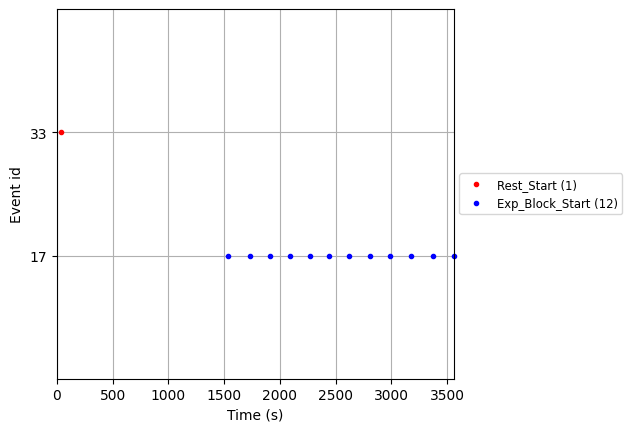

In [15]:
# Plot the events to get an idea of the paradigm - plotting only rest and task block events
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mne.viz.plot_events(events, eeg.info['sfreq'], eeg.first_samp, color=color, event_id=events_plot)

In [16]:
# Check duration of rest event
rest_st_ind = events[events[:, 2] == event_id['Rest_Start']][0][0]
rest_en_ind = events[events[:, 2] == event_id['Rest_End']][0][0]

In [17]:
# Check rest duration (in seconds)
(rest_en_ind - rest_st_ind) / eeg.info['sfreq']

120.004

### Epoching

In [18]:
# Define blocks of interest
rest_events = {'Rest_Start' : event_id['Rest_Start']}
task_blocks = {'Exp_Block_Start' : event_id['Exp_Block_Start']}

In [19]:
# Extract rest blocks, taking a ~2 minute time window
rest_epochs = mne.Epochs(eeg, events=events, event_id=rest_events, 
                         tmin=5, tmax=115, baseline=None, preload=True)

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 55001 original time points ...
0 bad epochs dropped


In [20]:
# Extract experiment blocks, taking a ~2 minute time window
exp_blocks = mne.Epochs(eeg, events=events, event_id=task_blocks, 
                        tmin=5, tmax=115, baseline=None, preload=True)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 55001 original time points ...
0 bad epochs dropped


### Marking bad moments 

Identifying bad moments based on visualization, and drop bad epochs.

In [21]:
# epochs.drop_bad()

### Visualizing Data

Using matplotlib as 2D backend.


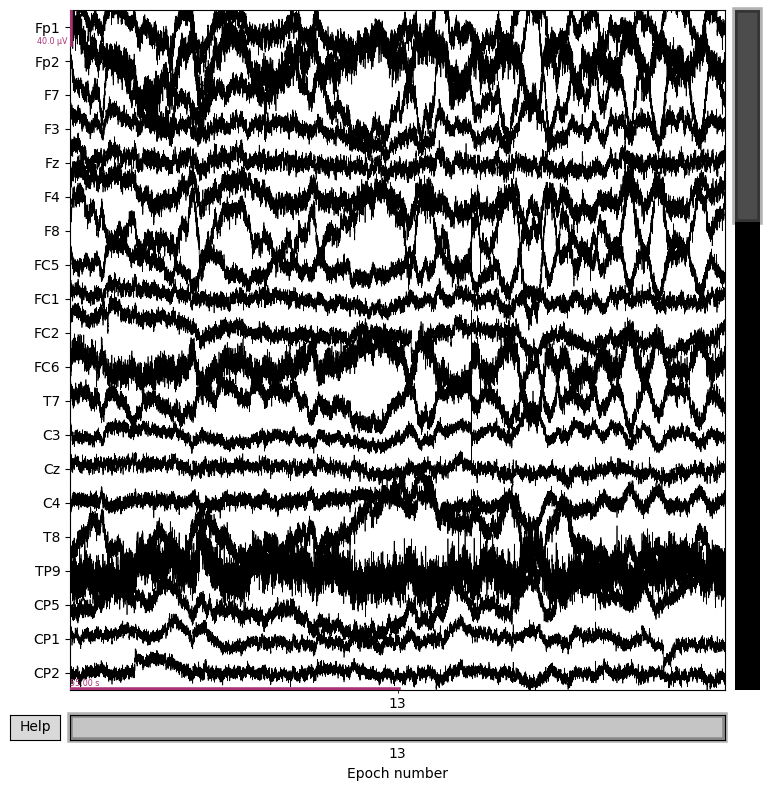

In [22]:
rest_epochs.plot();

## Analysis Checks

In [23]:
# Calculate PSDs
spectrum = rest_epochs.compute_psd('welch', fmin=1., fmax=50., n_fft=2000, n_overlap=250, n_per_seg=500)

Effective window size : 4.000 (s)


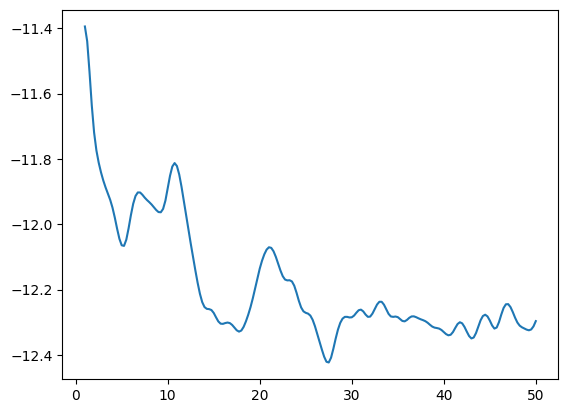

In [24]:
# Visualize an example power spectrum
plt.plot(spectrum.freqs, np.log10(spectrum._data[0, 30, :]))

# FOOOFing Data

In [25]:
fooof_psd = np.squeeze(spectrum._data[0, :, :])

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 32 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -10.9777, 1.4057                                         
                                                                                                  
                                       3 peaks were found:                                        
          

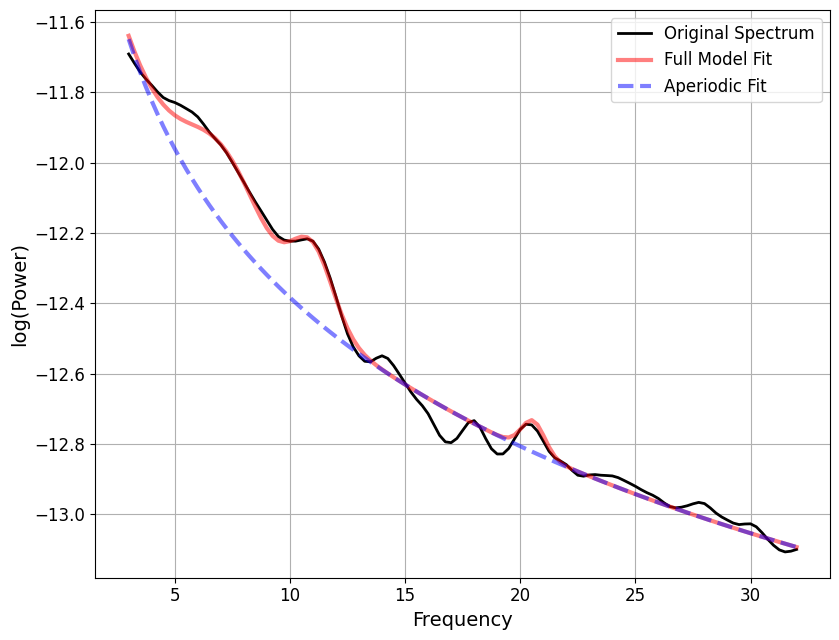

In [26]:
## Initialzing FOOOF model
fm = FOOOF(peak_width_limits=[1, 6], min_peak_height=0.075, max_n_peaks=6, peak_threshold=1)

# Setting frequency range
freq_range = [3, 32]

fm.report(spectrum.freqs, fooof_psd[40, :], freq_range)

In [27]:
# Run FOOOF across a group of PSDs
fg = FOOOFGroup(verbose=False)
fg.fit(spectrum.freqs, fooof_psd, freq_range)

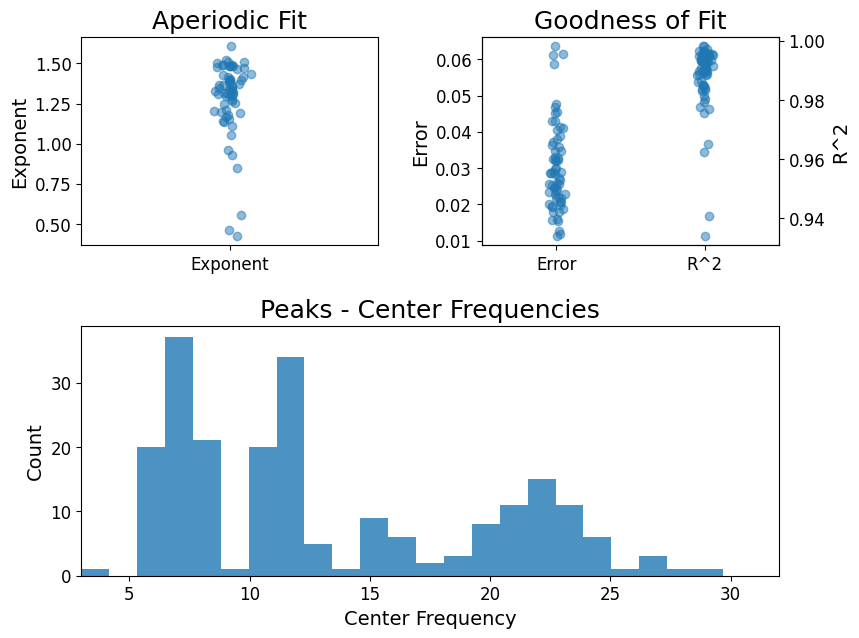

In [28]:
fg.plot()

In [29]:
n_channels, n_freq = fooof_psd.shape

In [30]:
fooof_results = np.zeros(shape = [n_channels, 3])
for ind, ch_dat in enumerate(fg.group_results):
    fooof_results[ind, :] = get_band_peak(ch_dat.peak_params, [8, 12])

In [31]:
cfs = np.nan_to_num(fooof_results[:, 0])
amps = np.nan_to_num(fooof_results[:, 1])
bws = np.nan_to_num(fooof_results[:, 2])

# Mapping

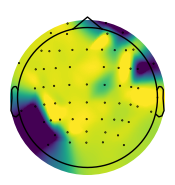

(<matplotlib.image.AxesImage at 0x7fc217231790>, None)

In [32]:
mne.viz.plot_topomap(cfs, rest_epochs.info, cmap=cm.viridis, contours=0, size=2)

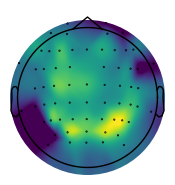

(<matplotlib.image.AxesImage at 0x7fc2172929d0>, None)

In [33]:
mne.viz.plot_topomap(amps, rest_epochs.info, cmap=cm.viridis, contours=0, size=2)

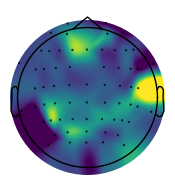

(<matplotlib.image.AxesImage at 0x7fc217754af0>, None)

In [34]:
mne.viz.plot_topomap(bws, rest_epochs.info, cmap=cm.viridis, contours=0, size=2)